# Guía de trabajo redes neuronales.

Para esta actividad deben construir una red neuronal como las vistas en clase (no se aceptan otros tipos de redes como las convolucionales o recurrentes). Para esta red neuronal deben realizar una búsqueda de hiperparámetros de tal forma que se maximice el rendimiento del modelo en el conjunto de prueba. Para la búsqueda de hiperparámetros, **se recomienda usar la búsqueda aleatoria.**

## Etapa 1: Carga de los datos.

Antes de comenzar a definir la red neuronal, cargamos la base de datos de interés. Para esta actividad, usaremos la base de datos Fashion-MNIST, la cual consiste en identificar tipos de prendas de vestir https://keras.io/api/datasets/fashion_mnist/. Esta base de datos configura un problema de 10 clases.

Se cargan las librerías necesarias

In [61]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils.vis_utils import plot_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

Se carga la base de datos y se divide en los conjunto de entrenamiento y prueba. Hay 60000 imágenes para el entrenamiento y 10000 en el conjunto de prueba.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [45]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [46]:
print(y_train.shape)
print(y_test.shape)

(60000,)
(10000,)


Las imágenes tienen tamaño 28x28. A continuación de muestran algunos ejemplos.


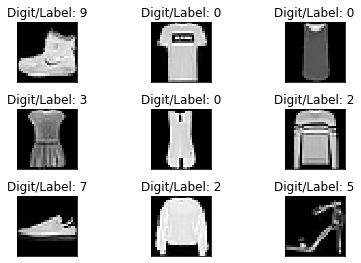

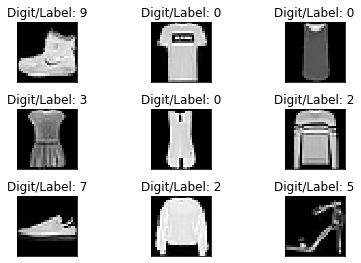

In [50]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(x_train[i], cmap='gray', interpolation='none')
  plt.title("Digit/Label: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

Procedemos a identificar la cantidad y los tipos de clases que existen en el datset

In [51]:
clases = np.unique(y_train)
for clase in clases:
    print(clase)
    
num_clases = len(clases)
print('Numero total de clases: ', num_clases)
print('Tipos de clases: ', clases)


0
1
2
3
4
5
6
7
8
9
Numero total de clases:  10
Tipos de clases:  [0 1 2 3 4 5 6 7 8 9]


Como podemos observar, hay 10 diferentes tipos de clases para cada prenda. A continuación, pasamos a identificar el nombre de cada una por su label o etiqueta y a imprimir los 10 primeros elementos con su respectivo label

In [52]:
nombres_clases = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}
# Estos labels se obtuvieron de la documentación del dataset

# Tensorflow: https://www.tensorflow.org/datasets/catalog/fashion_mnist
# Github: https://github.com/zalandoresearch/fashion-mnist

for i in range(10):
    label = y_train[i]
    nombre_clase = nombres_clases[label]
    print(f"Label {label}: {nombre_clase}")

Label 9: Ankle boot
Label 0: T-shirt/top
Label 0: T-shirt/top
Label 3: Dress
Label 0: T-shirt/top
Label 2: Pullover
Label 7: Sneaker
Label 2: Pullover
Label 5: Sandal
Label 5: Sandal


Normalizamos los datos de cada imagen para que las imágenes sean compatibles con las entradas de la red.

Hacemos uso de la operación de ***aplastamiento***
(Pasar de 0-255 a 0-1)

In [53]:
def normalizarData(x_train, x_test):
  d1, d2, d3 = x_train.shape
  x_train_flat = x_train.reshape((d1, d2*d3))/255
  d1, d2, d3 = x_test.shape
  x_test_flat = x_test.reshape((d1, d2*d3))/255
  return x_train_flat, x_test_flat

x_train_normalizado, x_test_normalizado = normalizarData(x_train, x_test)

print("x_train_normalizado: ", x_train_normalizado.shape)
print("x_test_normalizado: ", x_test_normalizado.shape)

x_train_normalizado:  (60000, 784)
x_test_normalizado:  (10000, 784)


Como vemos, Se mantienen las mismas 60000 imágenes del entrenaminento y se obtienen 784 atributos luego del proceso de aplastamiento. 28*28=784.

In [79]:
print("Conjunto datos de entrenamiento Normalizados (X_train)\n")
x_train_normalizado

Conjunto datos de entrenamiento Normalizados (X_train)



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [80]:
print("Conjunto datos de prueba Normalizados (X_test)\n")
x_test_normalizado

Conjunto datos de prueba Normalizados (X_test)



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [77]:
print("Conjunto datos de entrenamiento (Y_train)\n")
y_train

Conjunto datos de entrenamiento (Y_train)



array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [78]:
print("Conjunto datos de prueba (Y_test)\n")
y_test

Conjunto datos de prueba (Y_test)



array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

Ahora como el conjunto de datos de entrenamiento y prueba (Y_train, Y_test) son de tipo entero ( Class vector integers ), debemos convertirlos a datos de tipo categórico para manipularlos en el modelo.

Para esto usamos la función predeterminada de Keras ***utils.to_categorical***

***Converts a class vector (integers) to binary class matrix.***

Esta rutina hace uso del **One Hot Encoding**

In [83]:
from keras.utils import to_categorical
y_train_one_hot_encoding = to_categorical(y_train)
y_test_one_hot_encoding = to_categorical(y_test)

print('Label Original:', y_train[0])
print('Conversion con One Hot Encoding', y_train_one_hot_encoding[0])

Label Original: 9
Conversion con One Hot Encoding [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


Ahora hacemos la división de los ***datos normalizados*** en los conjuntos de ***entrenamiento y prueba***.

La proporción a usar es **70/30**

In [94]:
x_train_norm, x_test_norm, y_train_OneHot, y_test_OneHot = train_test_split(x_train_normalizado, y_train_one_hot_encoding, test_size = 0.3, shuffle=False)

Analizamos los tamaños de cada conjunto de datos

In [95]:
x_train_norm.shape, x_test_norm.shape, y_train_OneHot.shape, y_test_OneHot.shape

((42000, 784), (18000, 784), (42000, 10), (18000, 10))

In [97]:

print("x_train_normalizado: ", x_train_norm.shape)
print("x_test_normalizado: ", x_test_norm.shape)
print("y_train_one_hot_encoding: ", y_train_OneHot.shape)
print("y_test_one_hot_encoding: ", y_test_OneHot.shape)
                                                         

x_train_normalizado:  (42000, 784)
x_test_normalizado:  (18000, 784)
y_train_one_hot_encoding:  (42000, 10)
y_test_one_hot_encoding:  (18000, 10)


# Etapa 2: Entrenamiento de un sistema de aprendizaje automático eligiendo los hiper-parámetros de forma aleatoria.


Se realiza una búsqueda de hiperparámetros de tal forma que se maximice el rendimiento del modelo en el conjunto de prueba. Para la búsqueda de hiperparámetros, se usará el enfoque de la ***búsqueda aleatoria.***

Se entrena un clasificador basado en búsqueda aleatoria usando una configuración aleatoria.

In [98]:
# Se define el espacio de búsqueda. 

param_grid = {
    'criterion': ['gini', 'entropy'], # 2 opciones
    'min_samples_split': [2, 3, 4], # 3 opciones
    'min_samples_leaf': [1, 2, 3, 4, 5], # 5 opciones
    'max_features': ['auto', 'sqrt', 'log2'], # 3 opciones
    'max_depth': [5, 6, 7] # 3 opciones
    }

# La idea es probar todas las posibles configuraciones de los parámetros con el 
# fin de encontrar la que mejores resultados ofezca.
# Así se deben analizar 3*3*5*3*3=270 posibilidades

## 3.3 Búsqueda Aleatoria

Sabemos que en la búsqueda aleatoria la idea es escoger de forma aleatoria diferentes configuraciones de parámetros hasta encontrar la que produzca el mejor rendimiento. 

In [103]:
# Se crea el objeto para la búsqueda aleatoria
clf = DecisionTreeClassifier(random_state=0)
rs = RandomizedSearchCV(estimator=clf,
                  param_distributions=param_grid,
                  scoring='accuracy',
                  cv=5,
                  n_jobs=-1,
                  verbose=2,
                  n_iter=100 # Se define un número máximo de búsqueda
                  )

# búsqueda de la mejor configuración
time_start = time.time()
rs.fit(x_train_norm, y_train_OneHot)
time_random = time.time() - time_start

# se almacenna los resultados
values_grid = [ [100,rs.best_score_, time_random] ]
columns = ['Número de iteraciones', 'Mejor accuracy', 'Tiempo empleado']
results_random = pd.DataFrame(values_grid, columns = columns)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


Se analiza el rendimiento de la mejor configuración sobre el conjunto de prueba

In [104]:
print(classification_report( rs.predict(x_test_norm), y_test_OneHot) )

              precision    recall  f1-score   support

           0       0.69      0.82      0.75      1534
           1       0.87      0.98      0.92      1622
           2       0.36      0.71      0.48       959
           3       0.74      0.77      0.76      1723
           4       0.44      0.62      0.51      1277
           5       0.72      0.93      0.81      1383
           6       0.37      0.48      0.41      1337
           7       0.87      0.75      0.81      2030
           8       0.84      0.94      0.89      1589
           9       0.85      0.84      0.84      1824

   micro avg       0.67      0.79      0.73     15278
   macro avg       0.67      0.78      0.72     15278
weighted avg       0.71      0.79      0.74     15278
 samples avg       0.67      0.67      0.67     15278



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
